In [1]:
import pandas as pd
from scipy.stats import kstest
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 0. Configuration

Feature glossary: <br />
<ul>
<li>gender -> {0, 1} = {female, male}</li>
<li>rf (risk factors) -> {0, 1} = {no, yes}</li>
<li>sbp -> systolic blood pressure</li>
<li>hr{1, 2} -> heart rate {1, 2}</li>
<li>st -> st deviation -> {0, 1} = {no, yes}</li>
<li>crt -> creatinine</li>
<li>kil -> kilip class -> {1, 2, 3, 4}</li>
<li>target -> cardiovascular event ? {0, 1} = {no, yes}</li>
<li>cg -> clinical guidelines, defined in 1.c</li>
</ul>

In [2]:
datasetsFolder = '../datasets'
datasetName = f'{datasetsFolder}/DATA.txt'
datasetColumns = [
    'gender', 'age', 'rf',
    'sbp', 'hr1', 'st',
    'hr2', 'crt', 'kil',
    'target'
]
heartRateStd = {'hr1': 2, 'hr2': 0.5}

### 1. Importing and pre-processing the data

#### Importing the dataset

In [3]:
dataset = pd.read_csv(datasetName, sep='   ', header=None, engine='python')
dataset.columns = datasetColumns

#### Pre-processing

a. Convert discrete values to integer type

In [4]:
def convertToDataType(dataset, cols, datatype):
    for col in cols:
        dataset[col] = dataset[col].astype(datatype)
    return dataset

In [5]:
dataset = convertToDataType(
    dataset, 
    ['gender', 'age', 'rf', 'st', 'kil', 'target'],
    int
)

b. Get HR estimation based on hr1 and hr2

<img src='../images/two-sensor-data-fusion-1.png'></img>
<img src='../images/two-sensor-data-fusion-2.png'></img>

In [6]:
def getEstimation(dataset, std):
    std1Squared = std['hr1'] ** 2
    std2Squared = std['hr2'] ** 2
    k1 = std2Squared / (std1Squared + std2Squared)
    _k1 = std1Squared / (std1Squared + std2Squared)
    return k1 * dataset['hr1'] + _k1 * dataset['hr2']


In [7]:
dataset['hr'] = getEstimation(dataset, heartRateStd)

c. Add clinical guidelines to dataset
```
if ((crt >= 1.3 and st == 1) or kil >= 2)
    target = 1
```

In [8]:
guidelines = ((dataset['crt'] >= 1.3) & (dataset['st'] == 1)) | (dataset['kil'] >= 2)
dataset['cg'] = dataset['target'].where(guidelines, 0)

d. Test normality of continuous input variables with the Kolmogorov-Smirnov test and draw the respective histogram and density function.<br />

KS of sbp: KstestResult(statistic=1.0, pvalue=0.0)
KS of crt: KstestResult(statistic=0.7575100281124458, pvalue=3.215605939396061e-273)
KS of hr: KstestResult(statistic=1.0, pvalue=0.0)


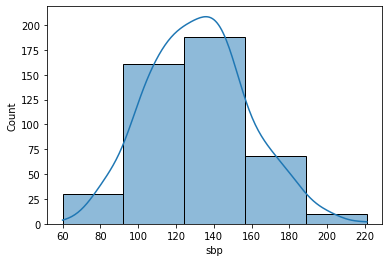

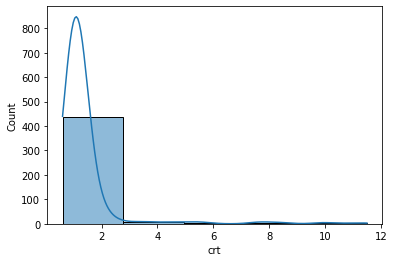

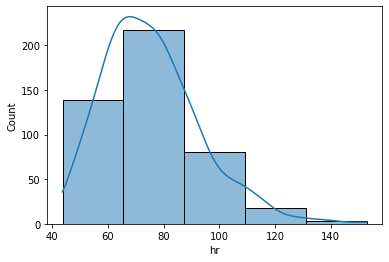

In [9]:
for col in ['sbp', 'crt', 'hr']:
    print(f'KS of {col}:', kstest(dataset[col], 'norm'))
    plt.figure()
    sns.histplot(
        dataset[col],
        bins=5,
        kde=True,
    )

Only 'sbp' follows a normal distribution, so we need to discretize the remaining variables (i.e 'crt', 'hr')

In [139]:
def discretize(dataset, col, nBins):
    bins = np.linspace(
        start=dataset[col].min(),
        stop=dataset[col].max(),
        num=nBins+1
    ).tolist()
    return pd.cut(x=dataset[col], bins=bins, include_lowest=True)
    

In [157]:
def getCounts(dataset, colName, nBins):
    bins = discretize(dataset, colName, nBins)
    df = pd.concat([dataset['target'], bins], axis=1)
    probs = {str(bin): [] for _, bin in enumerate(np.unique(bins))}
    for name, g in df.groupby(['target', colName]):
        probs[str(name[1])].append(len(g))
    
    for k, v in probs.items():
        if len(v) == 1:
            v.append(0)
        t = v[0] / (v[0] + v[1])
        _t = v[1] / (v[0] + v[1])
        probs[k][0] = t
        probs[k][1] = _t
    
    return probs

In [158]:
probs = {
    'crt': getCounts(dataset, 'crt', 3),
    'hr': getCounts(dataset, 'hr', 10),
}

print(probs)

{'crt': {'(0.599, 4.233]': [0.6199095022624435, 0.38009049773755654], '(4.233, 7.867]': [0.3333333333333333, 0.6666666666666666], '(7.867, 11.5]': [0.16666666666666666, 0.8333333333333334]}, 'hr': {'(43.804, 54.715]': [0.7073170731707317, 0.2926829268292683], '(54.715, 65.626]': [0.7346938775510204, 0.2653061224489796], '(65.626, 76.536]': [0.625, 0.375], '(76.536, 87.446]': [0.6288659793814433, 0.3711340206185567], '(87.446, 98.356]': [0.5636363636363636, 0.43636363636363634], '(98.356, 109.266]': [0.32, 0.68], '(109.266, 120.176]': [0.14285714285714285, 0.8571428571428571], '(120.176, 131.086]': [1.0, 0.0], '(131.086, 141.996]': [1.0, 0.0], '(141.996, 152.906]': [1.0, 0.0]}}


### 2. Processing the data

#### Discrete information

#### Continuous information